In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import datetime
import torch
import os
import importlib
import sys
import re
import pickle
from IPython.display import clear_output
from mpl_toolkits import mplot3d
from io import BytesIO
from math import log, exp, tan, atan, ceil
from PIL import Image

#from utils import dataset_utils
from utils import dataset_utils
from utils import createAISdata
#from utils import protobufDecoder
from utils import plotting
from models import VRNN
from Config import config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
#timestamp = datetime.datetime.fromtimestamp(update.t_epoch_sec).strftime('%d/%m/%Y %H:%M:%S')

>> Using device: cpu


## Data Preparation. Only run once

In [3]:
tracks = createAISdata.createAISdataset(
    {'ROI': (config.LAT_MIN, config.LAT_MAX, config.LON_MIN, config.LON_MAX), 
     'timeperiod': (config.T_MIN, config.T_MAX), 
     'maxspeed': config.SOG_MAX, 
     'navstatuses': config.MOV_NAV_STATUSES, 
     'shiptypes': config.SHIPTYPE_CARGO, 
     'binedges': binedges, 
     'minTrackLength': config.MIN_TRACKLENGTH,
     'maxTrackLength': config.MAX_TRACKLENGTH, 
     'minTrackUpdate': config.MIN_TRACKUPDATES, 
     'resampleFrequency': config.RESAMPLEFREQ
    },
    dataset_filename =  config.datapath
)

with open("data/all_" + "_" + shipFileName + ".pkl", "wb") as f:
        pickle.dump(tracks, f)
        
##dataset_utils.makeDatasetSplits(shipFileName, '24hour_' + shipFileName) ##Probably need to change this function

N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Finding MMSIs in ROI
processing filename:  C:\Users\asm\OneDrive - Netcompany\University\Master Thesis\Codebase\Data\aisMixJSON_1904XX\aisMixJSON_1904XX\Carg230368000_1904XX_DUMMY.json


KeyError: 1

## Define Datasets and Variables

In [2]:
shiptypes = config.SHIPTYPE_CARGO + config.SHIPTYPE_FISHING + config.SHIPTYPE_PASSENGER +config.SHIPTYPE_TANKER + config.SHIPTYPE_SAILING + config.SHIPTYPE_PLEASURE
shipFileName = 'CarFishPassTankSailPlea'
binedges = (config.LAT_EDGES, config.LON_EDGES, config.SOG_EDGES, config.COG_EDGES)
batch_size = 32

In [4]:
class PadSequence:
    def __call__(self, batch):
                
        # each element in "batch" is a tuple ( mmsis,  shiptypes,  lengths, inputs, targets)
        # Get each sequence and pad it
        mmsis = [x[0] for x in batch] # Maritime Mobile Service Identity numbers
        shiptypes = [x[1] for x in batch] # tank, cargo, etc.
        lengths = [x[2] for x in batch] # used as measure of size
        inputs = [x[3] for x in batch] # they are normalized 
        targets = [x[4] for x in batch] # seems to contain the real path of the vessel
                                        # lat, lon, speed, course (NOT NORMALIZED)
                
        inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
        targets_padded = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

        return  torch.tensor(mmsis),  torch.tensor(shiptypes),  torch.tensor(lengths, dtype=torch.float), inputs_padded, targets_padded

# different lengths (use max/min for dimensions) -> USE THIS ONE
trainset = dataset_utils.AISDataset("data/train_CarFishPassTankSailPlea.pkl")
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers = 0, collate_fn=PadSequence())
testset = dataset_utils.AISDataset("data/test_CarFishPassTankSailPlea.pkl", train_mean = trainset.mean)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, collate_fn=PadSequence())

# 144 data points per sampple (every 10min)
trainset_24hour = dataset_utils.AISDataset("data/train_24hour_CarFishPassTankSailPlea.pkl")
train_loader_24hour = torch.utils.data.DataLoader(trainset_24hour, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers = 0)
testset_24hour = dataset_utils.AISDataset("data/test_24hour_CarFishPassTankSailPlea.pkl", train_mean = trainset_24hour.mean)
test_loader_24hour = torch.utils.data.DataLoader(testset_24hour, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0)

train_n = len(trainset)
test_n = len(testset)
num_batches = len(train_loader)
num_epochs = ceil(80000/num_batches)

print(len(trainset))
print(len(testset))
print(len(trainset_24hour))
print(len(testset_24hour))

14538
188
449
112


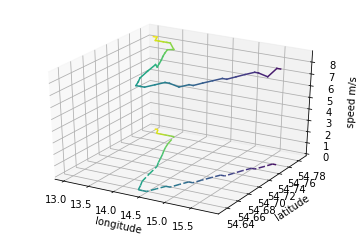

In [5]:
mmsi, _, _, _, x = trainset[0]
plotting.Plot4HotEncodedTrack(x, binedges, ax=None)

In [7]:
model = VRNN.VRNN(input_shape=trainset.datadim, latent_shape=100, generative_bias=trainset.mean, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

load_model = True
if load_model:
    modelName = 'model_' + shipFileName + '_150'
    model.load_state_dict(torch.load('models/saved_models/' + modelName +'.pth', map_location=device))

model.to(device)

def computeLoss(log_px, log_pz, log_qz, lengths, beta=1):
    
    max_len = len(log_px)
    curmask = torch.arange(max_len, device=device)[:, None] < lengths[None, :] #max_seq_len X Batch
    
    log_px = torch.stack(log_px, dim=0) * curmask
    log_px = log_px.sum(dim=0) #Sum over time
   
    log_pz = torch.stack(log_pz, dim=0) * curmask
    log_qz = torch.stack(log_qz, dim=0) * curmask
    kl = log_qz.sum(dim=0) - log_pz.sum(dim=0) #Sum over time
    
    loss = log_px - beta * kl #recon loss - beta_kl
    loss = torch.mean(loss/lengths) #mean over batch
    
    return -loss, log_px, kl

## Training Loops

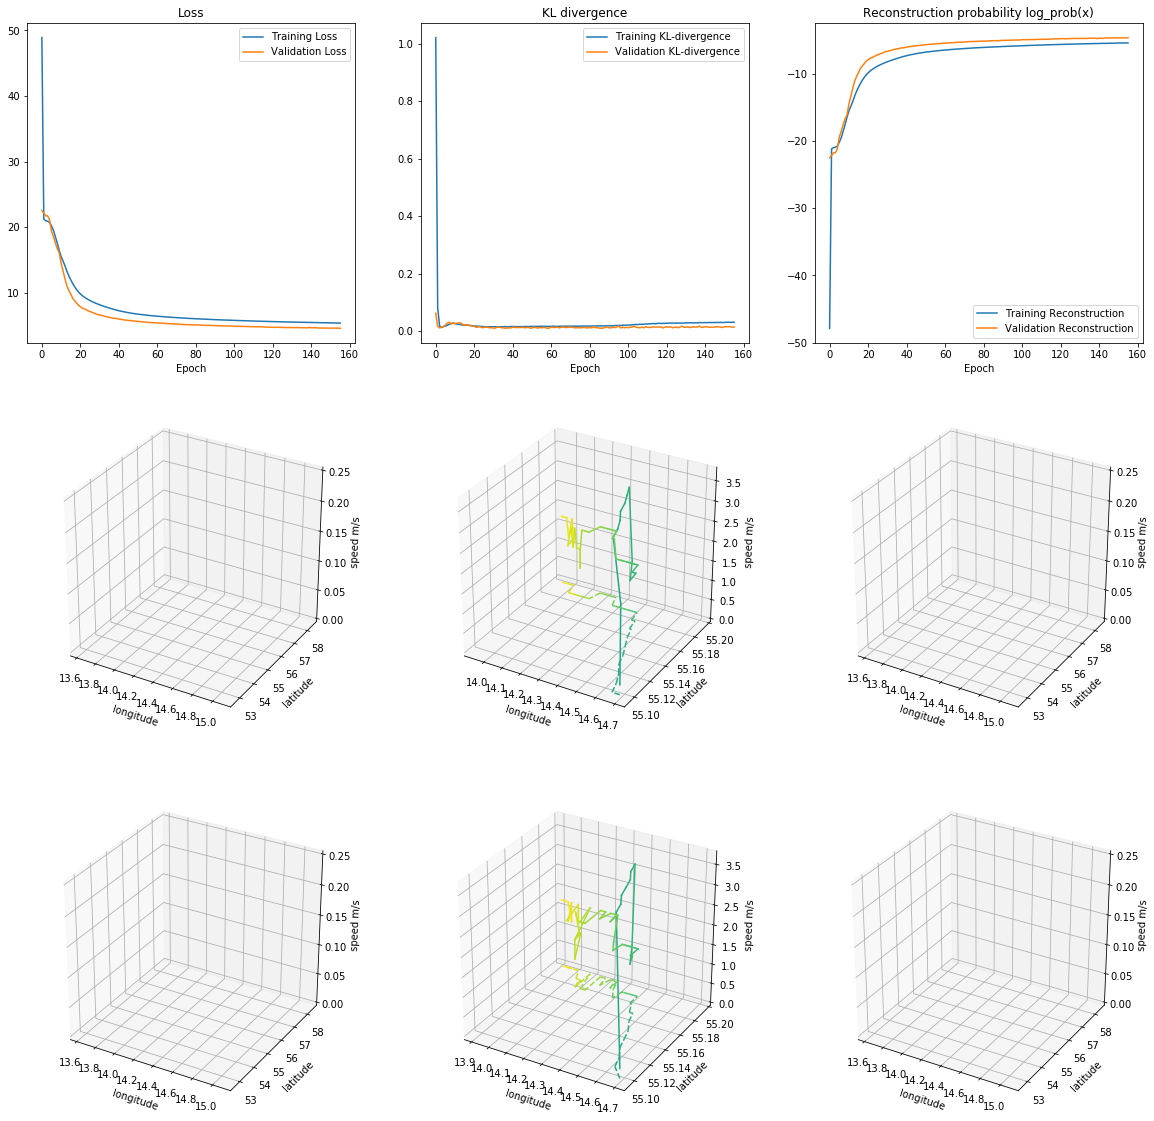

Epoch 156 of 176 finished. Trainingloss = 5.382165963194822. Validationloss = 4.582001574496005


In [ ]:
loss_tot = []
kl_tot = []
recon_tot = []
val_loss_tot = []
val_kl_tot = []
val_recon_tot = []
for epoch in range(1, num_epochs+1): #num_epochs+1
    #Begin training loop
    loss_epoch = 0
    kl_epoch = 0
    recon_epoch = 0
    model.train()
    for i, (_, _, lengths, inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        lengths = lengths.to(device)
        
        log_px, log_pz, log_qz, _, _ = model(inputs,targets,logits=None)
        
        loss, log_px, kl = computeLoss(log_px, log_pz, log_qz, lengths)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()*len(lengths)
        kl_epoch += torch.sum(kl/lengths).item()
        recon_epoch += torch.sum(log_px/lengths).item()
    
    loss_tot.append(loss_epoch/train_n)
    kl_tot.append(kl_epoch/train_n)
    recon_tot.append(recon_epoch/train_n)
    
    #Begin validation loop
    val_loss = 0
    val_kl = 0
    val_recon = 0
    model.eval()
    for i, (_, _, lengths, inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        lengths = lengths.to(device)
        
        log_px, log_pz, log_qz, _, _ = model(inputs,targets,logits=None)
        
        loss, log_px, kl = computeLoss(log_px, log_pz, log_qz, lengths)
                
        val_loss += loss.item()*len(lengths)
        val_kl += torch.sum(kl/lengths).item()
        val_recon += torch.sum(log_px/lengths).item()
    
    val_loss_tot.append(val_loss/test_n)
    val_kl_tot.append(val_kl/test_n)
    val_recon_tot.append(val_recon/test_n)
    
    datapoints = np.random.choice(test_n, size = 3, replace=False)
    plotting.make_vae_plots((loss_tot, kl_tot, recon_tot, val_loss_tot, val_kl_tot, val_recon_tot), model, datapoints, testset, binedges, device)
    
    print('Epoch {} of {} finished. Trainingloss = {}. Validationloss = {}'.format(epoch, num_epochs, loss_epoch/train_n, val_loss/test_n))
    
    if (epoch%10==0):
        torch.save(model.state_dict(), 'models/saved_models/model_' + shipFileName + '_' + str(epoch) + '.pth')
        
        trainingCurves = {
            'loss_tot': loss_tot,
            'kl_tot': kl_tot,
            'recon_tot': recon_tot,
            'val_loss_tot': val_loss_tot,
            'val_kl_tot': val_kl_tot,
            'val_recon_tot': val_recon_tot
        }
        with open('models/saved_models/trainingCurves_' + shipFileName + '.pkl', "wb") as f:
            pickle.dump(trainingCurves, f)
        

trainingCurves = {
    'loss_tot': loss_tot,
    'kl_tot': kl_tot,
    'recon_tot': recon_tot,
    'val_loss_tot': val_loss_tot,
    'val_kl_tot': val_kl_tot,
    'val_recon_tot': val_recon_tot
}

torch.save(model.state_dict(), 'models/model_' + shipFileName + '.pth')
with open('models/trainingCurves_' + shipFileName + '.pkl', "wb") as f:
        pickle.dump(trainingCurves, f)


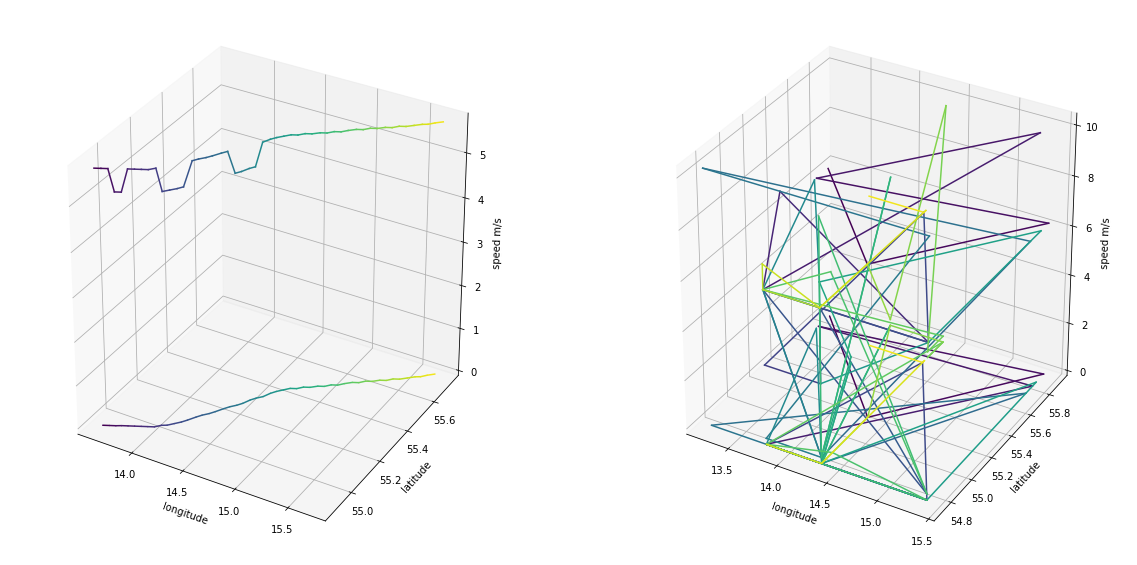

In [18]:
plotting.plot_recon(trainset[1], binedges,model,device)